# P118 HW1 - Tedi Godfrey
## Q3: Magnetic Bottle

### Sources Used:
1. https://github.com/epaco-dartmouth/phys118/blob/main/demos/week_1/PARTICLE_ORBITS.ipynb
2. chatGPT

In [102]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

### 3A
- Construct a magnetic bottle field by superposing two dipole fields.
- Make a plot of the resulting magnetic field configuration using field-line streamlines.

In [103]:
def Bdip1(r):
    'First Dipole Field'
    m = np.array([0.0,1.0])
    r1 = m # Shifting origin of field
    r_prime = r - r1
    r_mag = np.linalg.norm(r_prime) # magnitude of r
    B = (3*r_prime*(np.dot(m,r_prime)) - m*r_mag**2)/r_mag**5
    return B

def Bdip2(r):
    'Second Dipole Field'
    m = np.array([0.0,1.0])
    r1 = -m # shifting origin of field
    r_prime = r - r1
    r_mag = np.linalg.norm(r_prime) # magnitude of r
    B = (3*r_prime*(np.dot(m,r_prime)) - m*r_mag**2)/r_mag**5
    return B

def BdipTotal(r):
    'Dipole Field Superposition'
    B1 = Bdip1(r)
    B2 = Bdip2(r)
    return B1 + B2

In [104]:
'X and Z Vectors'
x = np.linspace(-3, 3, 301)
z = np.linspace(-3, 3, 301)
X, Z = np.meshgrid(x, z, indexing="xy")
V = np.stack([X, Z], axis=-1)  

In [105]:
'Vectorizing BdipTotal'
BdipTotal_vec = np.vectorize(BdipTotal, signature="(2)->(2)")

B_out = BdipTotal_vec(V)

B_out_x = B_out[:,:,0]

B_out_z = B_out[:,:,1]

/scratch/f005d7s/ipykernel_2274645/3313890165.py:16: RuntimeWarning: invalid value encountered in divide
  B = (3*r_prime*(np.dot(m,r_prime)) - m*r_mag**2)/r_mag**5
/scratch/f005d7s/ipykernel_2274645/3313890165.py:7: RuntimeWarning: invalid value encountered in divide
  B = (3*r_prime*(np.dot(m,r_prime)) - m*r_mag**2)/r_mag**5


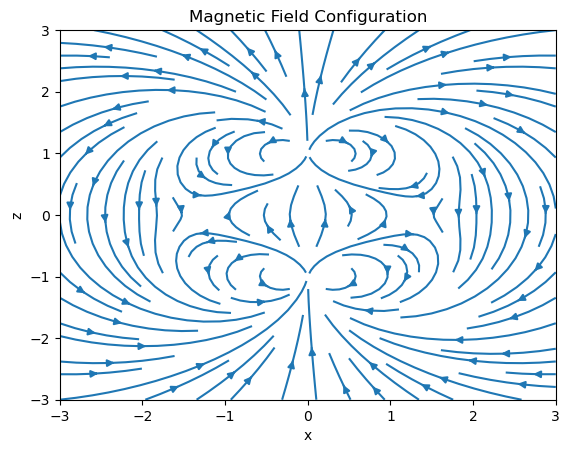

In [106]:
'Field-line Streamline Plot'
plt.streamplot(X,Z,B_out_x,B_out_z)
plt.xlabel('x')
plt.ylabel('z')
plt.title('Magnetic Field Configuration')
plt.show()

### 3B
- Integrate the trajectory of a charged particle launched from within the magnetic bottle using an upwind forward-Euler scheme. 
- The particle dynamics are governed by $ \frac{d\textbf{p}}{dt} = \textbf{F}_L = q\textbf{V} \times \textbf{B}, $ where $\textbf{p}=\gamma m\textbf{v}$ is the particle momentum, $\textbf{v}$ is the velocity, and $\textbf{B}$ is the fixed magnetic field of the bottle. 

- You may assume the non-relativistic limit $(\gamma =1)$ unless you choose otherwise. 

- Plot the particle trajectory and indicate whether the particle remains trapped.

In [107]:
# Making 3D

def Bdip1_3D(r):
    'First Dipole Field'
    m = np.array([0.0,0.0,1.0])
    r1 = m # Shifting origin of field
    r_prime = r - r1
    r_mag = np.linalg.norm(r_prime) # magnitude of r
    B = (3*r_prime*(np.dot(m,r_prime)) - m*r_mag**2)/r_mag**5
    return B

def Bdip2_3D(r):
    'Second Dipole Field'
    m = np.array([0.0,0.0,1.0])
    r1 = -m # shifting origin of field
    r_prime = r - r1
    r_mag = np.linalg.norm(r_prime) # magnitude of r
    B = (3*r_prime*(np.dot(m,r_prime)) - m*r_mag**2)/r_mag**5
    return B

def BdipTotal_3D(r):
    'Dipole Field Superposition'
    B1 = Bdip1_3D(r)
    B2 = Bdip2_3D(r)
    return B1 + B2

In [108]:
class Particle:
    def __init__(self, x, v, q, m):
        self.x = np.array(x, dtype=np.float64)
        self.v = np.array(v, dtype=np.float64)
        self.q = q
        self.m = m
        self.q_over_m = q / m

In [109]:
E = [0.0, 0.0, 0.0] # Just zero
dt = 0.01

In [110]:
def step_forward_euler(p, E, B, dt):
    vx, vy, vz = p.v
    Ex, Ey, Ez = E
    Bx, By, Bz = B

    cx = vy * Bz - vz * By
    cy = vz * Bx - vx * Bz
    cz = vx * By - vy * Bx

    dtqm = p.q_over_m * dt

    vx += dtqm * (Ex + cx)
    vy += dtqm * (Ey + cy)
    vz += dtqm * (Ez + cz)

    p.v[:] = vx, vy, vz
    p.x[:] += vx * dt, vy * dt, vz * dt

In [111]:
x_arr = []
v_arr = []
t_arr = []

p = Particle(
    x=[0.0, 0.0, 0.0],
    v=[0.2, 0.0, 0.0],
    q=1.0,
    m=1.0
)

In [112]:
nsteps = 5001

t0 = time.perf_counter()

for step in tqdm(range(nsteps)):
    t_arr.append(dt * step)
    x_arr.append(p.x.copy())
    v_arr.append(p.v.copy())
    B = BdipTotal_3D(p.x.copy())
    step_forward_euler(p, E, B, dt)

t1 = time.perf_counter()

avg_time_ns = (t1 - t0) / nsteps * 1e6
print(f"Average time per update: {avg_time_ns:.1f} ms")

100%|██████████| 5001/5001 [00:00<00:00, 41756.51it/s]

Average time per update: 24.2 ms


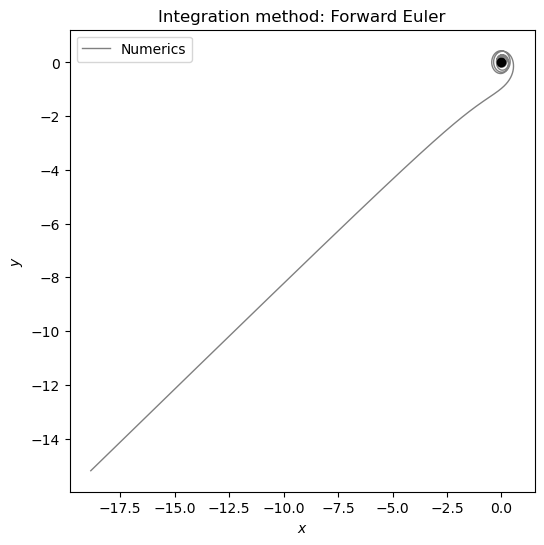

In [113]:
fig = plt.figure(figsize=(6, 6), dpi=100)
ax = fig.add_subplot(111)

x = np.transpose(x_arr)[0]
y = np.transpose(x_arr)[1]

# trajectory (numerics)
ax.plot(x, y, c='gray', lw=1.0, zorder=0, label='Numerics')

# initial point
x0, y0 = x[0], y[0]
ax.scatter(x0, y0, c='black', zorder=1)

ax.set_title('Integration method: Forward Euler') 
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.legend()
plt.show()

### The particle is not trapped for the forward-Euler method.

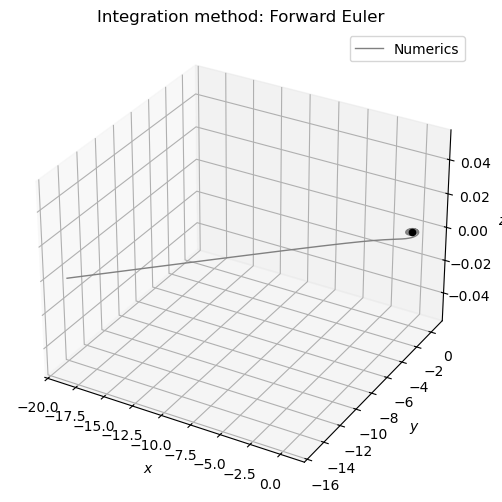

In [114]:
fig = plt.figure(figsize=(6, 6), dpi=100)
ax = fig.add_subplot(111,projection='3d')

x = np.transpose(x_arr)[0]
y = np.transpose(x_arr)[1]
z = np.transpose(x_arr)[2]

# trajectory (numerics)
ax.plot(x, y, z, c='gray', lw=1.0, zorder=0, label='Numerics')

# initial point
x0, y0, z0 = x[0], y[0], z[0]
ax.scatter(x0, y0, z0, c='black', zorder=1)

ax.set_title('Integration method: Forward Euler') 
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')
ax.legend()
plt.show()

### 3C
- Integrate the same initial condition using the Boris pusher.
- Plot the resulting trajectory and compare it directly to the forward-Euler result.

In [115]:
x_arr_2 = []
v_arr_2 = []
t_arr_2 = []

p = Particle(
    x=[0.0, 0.0, 0.0],
    v=[0.2, 0.0, 0.0],
    q=1.0,
    m=1.0
)

In [116]:
def update_velocity_boris(p, E, B, dt):
    """
    Standard Boris pusher (scalar, allocation-free)
    """

    # unpack
    vx, vy, vz = p.v
    Ex, Ey, Ez = E
    Bx, By, Bz = B

    qm = p.q_over_m
    h = 0.5 * qm * dt

    # --- t vector ---
    tx = h * Bx
    ty = h * By
    tz = h * Bz

    # --- |t|^2 ---
    t_mag2 = tx*tx + ty*ty + tz*tz

    # --- s vector ---
    inv = 2.0 / (1.0 + t_mag2)
    sx = tx * inv
    sy = ty * inv
    sz = tz * inv

    # --- v minus ---
    vxm = vx + h * Ex
    vym = vy + h * Ey
    vzm = vz + h * Ez

    # --- v prime = v_minus + v_minus × t ---
    vpx = vxm + (vym*tz - vzm*ty)
    vpy = vym + (vzm*tx - vxm*tz)
    vpz = vzm + (vxm*ty - vym*tx)

    # --- v plus = v_minus + v_prime × s ---
    vxp = vxm + (vpy*sz - vpz*sy)
    vyp = vym + (vpz*sx - vpx*sz)
    vzp = vzm + (vpx*sy - vpy*sx)

    # --- final velocity ---
    vx = vxp + h * Ex
    vy = vyp + h * Ey
    vz = vzp + h * Ez

    p.v[:] = vx, vy, vz

In [117]:
def step_boris(p, E, B, dt):
    update_velocity_boris(p, E, B, dt)
    p.x += p.v * dt

In [118]:
nsteps = 5001

t0 = time.perf_counter()

for step in tqdm(range(nsteps)):
    t_arr_2.append(dt * step)
    x_arr_2.append(p.x.copy())
    v_arr_2.append(p.v.copy())
    B = BdipTotal_3D(p.x.copy())
    step_boris(p, E, B, dt)

t1 = time.perf_counter()

avg_time_ns = (t1 - t0) / nsteps * 1e6
print(f"Average time per update: {avg_time_ns:.1f} ms")

100%|██████████| 5001/5001 [00:00<00:00, 41317.70it/s]

Average time per update: 24.5 ms


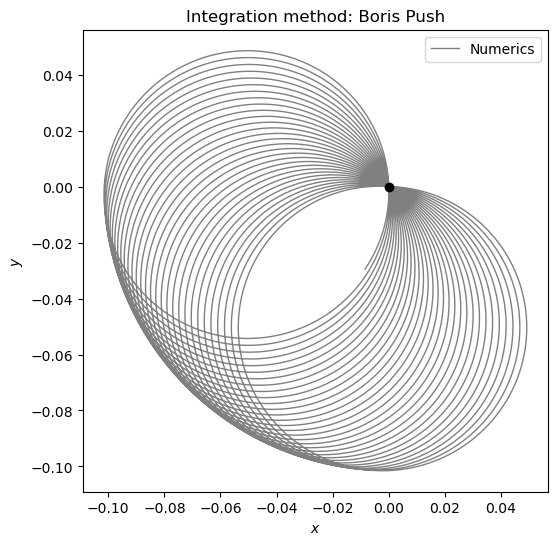

In [119]:
fig = plt.figure(figsize=(6, 6), dpi=100)
ax = fig.add_subplot(111)

x = np.transpose(x_arr_2)[0]
y = np.transpose(x_arr_2)[1]

# trajectory (numerics)
ax.plot(x, y, c='gray', lw=1.0, zorder=0, label='Numerics')

# initial point
x0, y0 = x[0], y[0]
ax.scatter(x0, y0, c='black', zorder=1)

ax.set_title('Integration method: Boris Push')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.axis('equal')
ax.legend()
plt.show()

### The particle is trapped for the Boris push method.

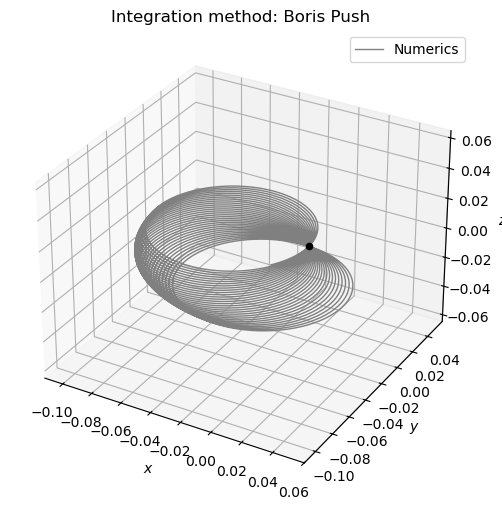

In [120]:
fig = plt.figure(figsize=(6, 6), dpi=100)
ax = fig.add_subplot(111,projection='3d')

x = np.transpose(x_arr_2)[0]
y = np.transpose(x_arr_2)[1]
z = np.transpose(x_arr_2)[2]

# trajectory (numerics)
ax.plot(x, y, z, c='gray', lw=1.0, zorder=0, label='Numerics')

# initial point
x0, y0, z0 = x[0], y[0], z[0]
ax.scatter(x0, y0, z0, c='black', zorder=1)

ax.set_title('Integration method: Boris Push')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')
ax.axis('equal')
ax.legend()
plt.show()

### 3D 
- Compute the particle kinetic energy, $ E_{kin}(t)=\frac{1}{2}m|\textbf{v}(t)|^2, $ as a function of time for both integration schemes. 
- Compare the energy evolution and comment on the numerical behavior of each method.
- Which integrator is more physically reliable, and why?

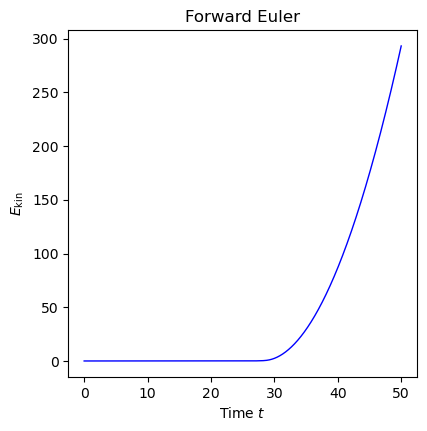

In [121]:
fig = plt.figure(figsize=(4.5, 4.5), dpi=100)
plt.plot(t_arr, 0.5*(np.transpose(x_arr)[0]**2+np.transpose(x_arr)[1]**2+np.transpose(x_arr)[2]**2), c='blue', lw=1.0)
plt.xlabel(r'Time $t$')
plt.ylabel(r'$E_{\rm kin}$')
plt.title('Forward Euler')
plt.show()

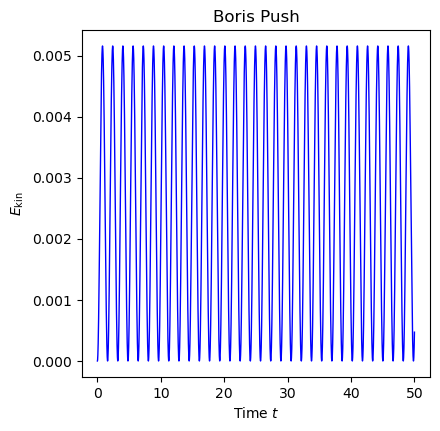

In [122]:
fig = plt.figure(figsize=(4.5, 4.5), dpi=100)
plt.plot(t_arr_2, 0.5*(np.transpose(x_arr_2)[0]**2+np.transpose(x_arr_2)[1]**2+np.transpose(x_arr_2)[2]**2), c='blue', lw=1.0)
plt.xlabel(r'Time $t$')
plt.ylabel(r'$E_{\rm kin}$')
plt.title('Boris Push')
plt.show()

### The Boris method is numerical stable ebcause the particle remains bounded. 
### The forward-Euler method is numerically unstable, so the particle does not remain trapped. We can see this in the energy over time plot because the energy grows unbounded with respect to time. 
